In [90]:
import polars as pl
import glob
import os

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc
import seaborn as sns
import numpy as np
import scipy.stats as stats
from typing import List, Dict, Optional, Union

### Helper Functions section

In [2]:
def get_roc(truths: pl.Series, scores: pl.Series, model: str = None) -> pl.DataFrame:
    roc = pl.DataFrame(roc_curve(truths, scores), schema = ["fpr", "tpr", "roc_thresholds"]).with_columns(pl.lit(model).alias("model"))
    return roc

def get_prc(truths: pl.Series, scores: pl.Series, model: str = None) -> pl.DataFrame:
    precision, recall, thresholds = precision_recall_curve(truths, scores)
    pr = pl.DataFrame({
        'Threshold': np.append(thresholds, np.inf, axis=None),
        'Precision': precision,
        'Recall': recall
    }).with_columns(pl.lit(model).alias("model"))

    return pr

In [45]:
def read_features(path: str) -> pl.DataFrame:
    df = (
        pl.read_csv(path, separator="\t")
        .with_columns(pl.col("id").str.replace(":", "_").alias("id_temp"))
        .with_columns(snv = (pl.col("id_temp") + pl.lit("_") + pl.col("ref.allele") + pl.lit("_") + pl.col("alt.allele")))
        .drop("id_temp")
	)
    return df

In [52]:
def predict(labeled_scores: pl.DataFrame, threshold: bool, select_necessary: bool = True, sort: bool = True) -> pl.DataFrame:
	
	if select_necessary:
		labeled_scores = labeled_scores.select(["snv", "score", "truth"])
	
	pred = labeled_scores.with_columns(
		pl.when(pl.col("score") >= threshold)  # If score is higher/equal, it's True
		.then(pl.lit(True))
		.otherwise(pl.lit(False))
		.alias("pred")
	)
	
	if sort:
		pred = pred.sort("score")

	return pred

In [89]:
def plot_roc(
    df: pl.DataFrame, 
    fpr_col: str = "fpr", 
    tpr_col: str = "tpr", 
    model_col: str = "model",
    points: Optional[List[Dict[str, Union[float, str]]]] = None
) -> None:
    """
    Plots ROC curves for different models and optionally overlays specific data points.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the ROC curve data.
    fpr_col : str
        Name of the column containing False Positive Rates.
    tpr_col : str
        Name of the column containing True Positive Rates.
    model_col : str
        Name of the column distinguishing different models (for the hue).
    points : list of dicts, optional
        A list of dictionaries to plot specific points. 
        Each dict should have keys: 'x', 'y', 'color', and optionally 'label'.
        Example: [{'x': 0.41, 'y': 0.90, 'color': 'blue', 'label': 'Model A Cutoff'}]
    """
    
    # Set theme
    sns.set_theme(font_scale=1.5, style="white")
    plt.figure(figsize=(5, 5))
    
    # Plot the main ROC lines
    sns.lineplot(
        data=df, 
        x=fpr_col, 
        y=tpr_col, 
        hue=model_col, 
        estimator=None, 
        linewidth=3, 
        alpha=0.67
    )
    
    # Plot the Random Guess line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    
    # Iterate through the dynamic points list
    if points:
        for p in points:
            # Extract values with defaults if keys are missing
            x_val = p.get('x')
            y_val = p.get('y')
            color = p.get('color', 'black') # Default to black if no color provided
            label = p.get('label', None)
            
            if x_val is not None and y_val is not None:
                plt.plot(
                    x_val, 
                    y_val, 
                    marker='x', 
                    color=color, 
                    markersize=10, 
                    markeredgewidth=3, # 'mew' alias
                    alpha=0.5,
                    label=label,
                    linestyle="None" # Ensure we only plot the marker, not a line connecting them
                )

    # Labels and Limits
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    
    # # Handle Legend (deduplicate if points added labels)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize='small')
    
    plt.show()


### Explore Scores

Pick samples where ideafix performs better than MOBSNVF

In [12]:
## FFPE WES scores. DP >= 10
scores = pl.read_csv("../eval-wes-wgs-gt-union/mutect2-matched-normal_pass-orientation-dp20-filtered_micr.vs.filtered-ff/FFX/roc-prc-auc/precrec/combined_auc_table.tsv", separator = "\t")
scores

sample_name,model,auroc,auprc
str,str,f64,f64
"""all-ffpe-wes-samples""","""ideafix-rf""",0.723031,0.898983
"""all-ffpe-wes-samples""","""ideafix-xgboost""",0.720009,0.899406
"""all-ffpe-wes-samples""","""mobsnvf""",0.643181,0.963796
"""all-ffpe-wes-samples""","""sobdetector""",0.649267,0.965753
"""all-ffpe-wes-samples""","""vafsnvf""",0.877575,0.992433
…,…,…,…
"""FFX_IL_T_6h_1""","""ideafix-rf""",0.660461,0.89928
"""FFX_IL_T_6h_1""","""ideafix-xgboost""",0.698877,0.925824
"""FFX_IL_T_6h_1""","""mobsnvf""",0.606984,0.967352


In [20]:
# Samples where Ideafix has higher AUROC
ideafix_higher_auroc = scores.filter(
    pl.col("auroc").filter(pl.col("model").str.contains("ideafix")).max().over("sample_name") >
    pl.col("auroc").filter(pl.col("model") == "mobsnvf").first().over("sample_name")
).filter(pl.col("model").is_in(["ideafix-rf", "ideafix-xgboost", "mobsnvf", "vafsnvf"]))

ideafix_higher_auroc

sample_name,model,auroc,auprc
str,str,f64,f64
"""all-ffpe-wes-samples""","""ideafix-rf""",0.723031,0.898983
"""all-ffpe-wes-samples""","""ideafix-xgboost""",0.720009,0.899406
"""all-ffpe-wes-samples""","""mobsnvf""",0.643181,0.963796
"""all-ffpe-wes-samples""","""vafsnvf""",0.877575,0.992433
"""FFX_GZ_T_24h_1""","""ideafix-rf""",0.731143,0.947734
…,…,…,…
"""FFX_IL_T_2h_1""","""vafsnvf""",0.894569,0.989321
"""FFX_IL_T_6h_1""","""ideafix-rf""",0.660461,0.89928
"""FFX_IL_T_6h_1""","""ideafix-xgboost""",0.698877,0.925824


In [15]:
## Sample where Ideafix has higher AUPRC
scores.filter(
    pl.col("auprc").filter(pl.col("model").str.contains("ideafix")).max().over("sample_name") >
    pl.col("auprc").filter(pl.col("model") == "mobsnvf").first().over("sample_name")
)

sample_name,model,auroc,auprc
str,str,f64,f64


In [24]:
## Get the sample name set
samples = ideafix_higher_auroc.filter(~pl.col("sample_name").str.contains("all-")).get_column("sample_name").unique()
samples

sample_name
str
"""FFX_IL_T_24h_1"""
"""FFX_IL_T_1h_1"""
"""FFX_IL_T_2h_1"""
"""FFX_GZ_T_24h_2"""
"""FFX_IL_T_6h_1"""
"""FFX_GZ_T_24h_1"""


### Single Sample Exploration

Looking into one of the sample: FFX_GZ_T_24h_1

#### Pick Threshold and Predict Artifacts

In [65]:
ideafix_scores = pl.read_csv("../eval-wes-wgs-gt-union/mutect2-matched-normal_pass-orientation-dp-filtered_micr.vs.filtered-ff/FFX/model-scores_truths/FFX_GZ_T_24h_1/FFX_GZ_T_24h_1_ideafix-rf-scores_truths.tsv", separator="\t")
mobsnvf_scores = pl.read_csv("../eval-wes-wgs-gt-union/mutect2-matched-normal_pass-orientation-dp-filtered_micr.vs.filtered-ff/FFX/model-scores_truths/FFX_GZ_T_24h_1/FFX_GZ_T_24h_1_mobsnvf-scores_truths.tsv", separator="\t")
features = read_features("../ffpe-snvf/mutect2-matched-normal_pass-orientation-filtered/FFX/ideafix/FFX_GZ_T_24h_1/FFX_GZ_T_24h_1.ideafix.descriptors.tsv")

In [40]:
ideafix_roc = get_roc(ideafix_scores["truth"], ideafix_scores["score"], model="ideafix")
# ideafix_pr = get_prc(ideafix_scores["truth"], ideafix_scores["score"], model="ideafix")
mobsnvf_roc = get_roc(mobsnvf_scores["truth"], mobsnvf_scores["score"], model="mobsnvf")
# mobsnvf_pr = get_prc(mobsnvf_scores["truth"], mobsnvf_scores["score"], model="mobsnvf")

In [31]:
roc = pl.concat([ideafix_roc, mobsnvf_roc])
roc

fpr,tpr,roc_thresholds,model
f64,f64,f64,str
0.0,0.0,inf,"""ideafix"""
0.0,0.009174,-0.276305,"""ideafix"""
0.0,0.110092,-0.383938,"""ideafix"""
0.058824,0.110092,-0.393376,"""ideafix"""
0.058824,0.376147,-0.541525,"""ideafix"""
…,…,…,…
0.68,0.926,-1.9207e-14,"""mobsnvf"""
0.68,0.978,-1.5224e-8,"""mobsnvf"""
0.72,0.978,-1.6640e-8,"""mobsnvf"""


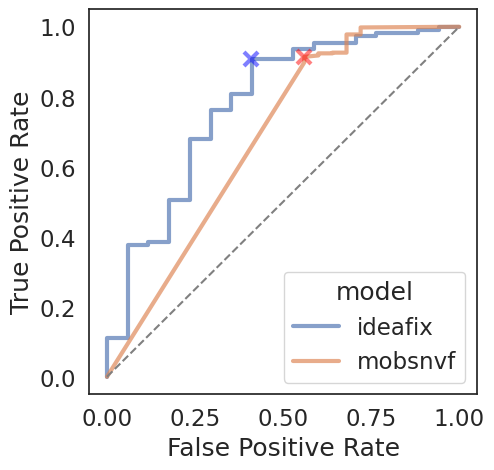

In [ ]:
cutoffs = [
    {"x": 0.41, "y": 0.908, "color":'blue'},
	{"x": 0.56, "y": 0.914, "color":'red'}
]

plot_roc(roc, points=cutoffs)

In [56]:
# Predict mobsnvf based on threshold
mobsnvf_pred = predict(mobsnvf_scores, -6.66134e-16)
mobsnvf_pred

snv,score,truth,pred
str,f64,bool,bool
"""chr2_151255605_C_T""",-1.0,false,false
"""chr7_12570326_C_T""",-1.0,false,false
"""chr7_57177915_G_A""",-1.0,true,false
"""chr9_92677269_G_A""",-1.0,false,false
"""chr12_88229945_C_T""",-1.0,false,false
…,…,…,…
"""chrX_120441683_G_A""",0.0,true,true
"""chrX_124022741_C_T""",0.0,true,true
"""chrX_152700708_G_A""",0.0,true,true


In [54]:
## Misclassified SNVs
mobsnvf_misclass = mobsnvf_pred.filter(pl.col("truth") != pl.col("pred"))
mobsnvf_misclass

snv,score,truth,pred
str,f64,bool,bool
"""chr7_57177915_G_A""",-1.0,true,false
"""chr20_34882686_C_T""",-0.002144,true,false
"""chr13_41384677_G_A""",-0.000534,true,false
"""chr10_48963723_C_T""",-0.000514,true,false
"""chr19_54698073_G_A""",-0.000096,true,false
…,…,…,…
"""chr16_31473862_G_A""",0.0,false,true
"""chr17_76353649_C_T""",0.0,false,true
"""chr18_36742907_C_T""",0.0,false,true


In [55]:
mobsnvf_correct = mobsnvf_pred.filter(pl.col("truth") == pl.col("pred"))
mobsnvf_correct

snv,score,truth,pred
str,f64,bool,bool
"""chr2_151255605_C_T""",-1.0,false,false
"""chr7_12570326_C_T""",-1.0,false,false
"""chr9_92677269_G_A""",-1.0,false,false
"""chr12_88229945_C_T""",-1.0,false,false
"""chr17_43371679_G_A""",-1.0,false,false
…,…,…,…
"""chrX_120441683_G_A""",0.0,true,true
"""chrX_124022741_C_T""",0.0,true,true
"""chrX_152700708_G_A""",0.0,true,true


In [57]:
## Make ideafix predictions based on the threshold
ideafix_pred = predict(ideafix_scores, -0.862937024430372)
ideafix_pred

snv,score,truth,pred
str,f64,bool,bool
"""chr20_56634370_G_A""",-0.999019,false,false
"""chr2_44943065_G_A""",-0.998609,true,false
"""chr7_12570326_C_T""",-0.989607,false,false
"""chr12_6938930_C_T""",-0.987982,true,false
"""chr12_88229945_C_T""",-0.987103,false,false
…,…,…,…
"""chr14_81032664_G_A""",-0.33731,true,true
"""chr6_2840643_G_A""",-0.336786,true,true
"""chr16_89859116_G_A""",-0.328196,true,true


In [59]:
## SNVs misclassified by ideafix
ideafix_misclass = ideafix_pred.filter(pl.col("truth") != pl.col("pred"))
ideafix_misclass

snv,score,truth,pred
str,f64,bool,bool
"""chr2_44943065_G_A""",-0.998609,true,false
"""chr12_6938930_C_T""",-0.987982,true,false
"""chr7_57177915_G_A""",-0.978336,true,false
"""chr8_123140750_G_A""",-0.967528,true,false
"""chr6_7585458_C_T""",-0.956898,true,false
…,…,…,…
"""chr16_31473862_G_A""",-0.715879,false,true
"""chr7_102465725_G_A""",-0.624925,false,true
"""chr8_143839578_C_T""",-0.562669,false,true


In [63]:
## SNVs which ideafix got correct by ideafix got wrong
ideafix_correct_mosnvf_wrong = mobsnvf_misclass.join(ideafix_misclass, on="snv", how="anti")
ideafix_correct_mosnvf_wrong

snv,score,truth,pred
str,f64,bool,bool
"""chr20_34882686_C_T""",-0.002144,true,false
"""chr13_41384677_G_A""",-0.000534,true,false
"""chr10_48963723_C_T""",-0.000514,true,false
"""chr19_54698073_G_A""",-0.000096,true,false
"""chr20_38000259_G_A""",-0.000083,true,false
…,…,…,…
"""chr10_30029108_C_T""",0.0,false,true
"""chr10_61429019_C_T""",0.0,false,true
"""chr11_802515_C_T""",0.0,false,true


In [64]:
## SNVs which MOBSNVF got correct but idefix got wrong
mobsnvf_correct_ideafix_wrong = ideafix_misclass.join(mobsnvf_misclass, on="snv", how="anti")
mobsnvf_correct_ideafix_wrong

snv,score,truth,pred
str,f64,bool,bool
"""chr2_44943065_G_A""",-0.998609,true,false
"""chr12_6938930_C_T""",-0.987982,true,false
"""chr8_123140750_G_A""",-0.967528,true,false
"""chr6_7585458_C_T""",-0.956898,true,false
"""chr16_22000910_G_A""",-0.92904,true,false
"""chr6_83523696_G_A""",-0.92902,true,false
"""chr19_54638714_C_T""",-0.916942,true,false
"""chr9_130307566_G_A""",-0.916367,true,false
"""chr17_43371679_G_A""",-0.805601,false,true


#### Feature Comparisons

Feature of interest is Fragment length

In [66]:
ideafix_correct_mosnvf_wrong_features = features.join(ideafix_correct_mosnvf_wrong, on="snv", how="semi")
ideafix_correct_mosnvf_wrong_features

allele.freq,alt.bases,norm.alt.bases,ref.bases,norm.ref.bases,ref.allele,alt.allele,base.qual,base.qual.frac,frag.length,pos.from.end,map.qual,FdeamC,SOB,SBGuo,SBGATK,id,both.reads.aligned,norm.pos.from.end,current,bases,before.2,before.1,after.1,after.2,before,after,is.repeat.region,snv
f64,i64,f64,i64,f64,str,str,i64,f64,i64,i64,str,f64,f64,f64,f64,str,i64,f64,str,str,str,str,str,str,str,str,bool,str
0.126,16,0.133333,104,0.866667,"""C""","""T""",20,0.540541,183,31,"""NA""",0.666667,0.333333,0.22792,0.155599,"""chr2:97211773""",1,0.169399,"""C""","""TTCGG""","""T""","""T""","""G""","""G""","""TT""","""GG""",false,"""chr2_97211773_C_T"""
0.268,8,0.242424,25,0.757576,"""G""","""A""",41,1.0,227,16,"""NA""",0.6,-0.2,0.226648,0.29011,"""chr4:108009752""",1,0.070485,"""G""","""TTGCT""","""T""","""T""","""C""","""T""","""TT""","""CT""",false,"""chr4_108009752_G_A"""
0.202,21,0.179487,96,0.820513,"""C""","""T""",32,0.864865,194,24,"""NA""",0.625,0.25,0.185714,0.203125,"""chr5:34954593""",1,0.123711,"""C""","""TCCAT""","""T""","""C""","""A""","""T""","""TC""","""AT""",false,"""chr5_34954593_C_T"""
0.24,7,0.225806,24,0.774194,"""C""","""T""",20,0.47619,132,29,"""NA""",0.4,-0.2,0.350595,0.279861,"""chr9:77358275""",1,0.219697,"""C""","""TTCTT""","""T""","""T""","""T""","""T""","""TT""","""TT""",false,"""chr9_77358275_C_T"""
0.249,3,0.2,12,0.8,"""G""","""A""",41,0.97619,247,22,"""NA""",0.666667,-0.333333,1.153565,0.288449,"""chr9:136764600""",1,0.089069,"""G""","""AAGCG""","""A""","""A""","""C""","""G""","""AA""","""CG""",false,"""chr9_136764600_G_A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.295,13,0.302326,30,0.697674,"""G""","""A""",20,0.487805,172,29,"""NA""",0.666667,-0.333333,0.390138,0.404274,"""chr19:16361782""",1,0.168605,"""G""","""GAGGT""","""G""","""A""","""G""","""T""","""GA""","""GT""",false,"""chr19_16361782_G_A"""
0.267,8,0.25,24,0.75,"""C""","""T""",35,0.853659,216,18,"""NA""",0.833333,0.666667,0.0,0.25,"""chr20:34882686""",1,0.083333,"""C""","""TCCTA""","""T""","""C""","""T""","""A""","""TC""","""TA""",false,"""chr20_34882686_C_T"""
0.227,4,0.190476,17,0.809524,"""G""","""A""",41,0.97619,276,29,"""NA""",0.75,-0.5,1.104978,0.26005,"""chr20:38000259""",1,0.105072,"""G""","""GGGAG""","""G""","""G""","""A""","""G""","""GG""","""AG""",false,"""chr20_38000259_G_A"""


In [67]:
ideafix_correct_mosnvf_wrong_features["frag.length"].describe()

statistic,value
str,f64
"""count""",17.0
"""null_count""",0.0
"""mean""",217.764706
"""std""",59.53416
"""min""",132.0
"""25%""",175.0
"""50%""",198.0
"""75%""",247.0
"""max""",351.0


<Axes: xlabel='frag.length', ylabel='Count'>

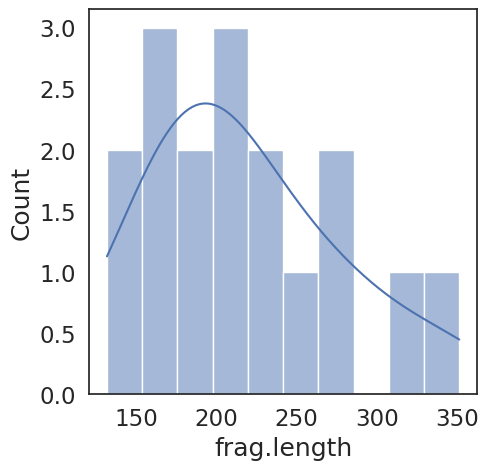

In [76]:
plt.figure(figsize=(5, 5))
sns.histplot(data=ideafix_correct_mosnvf_wrong_features, x="frag.length", bins=10, kde=True, kde_kws={"bw_adjust": 1})

In [71]:
mobsnvf_correct_ideafix_wrong_features = features.join(mobsnvf_correct_ideafix_wrong, on="snv", how="semi")
mobsnvf_correct_ideafix_wrong_features

allele.freq,alt.bases,norm.alt.bases,ref.bases,norm.ref.bases,ref.allele,alt.allele,base.qual,base.qual.frac,frag.length,pos.from.end,map.qual,FdeamC,SOB,SBGuo,SBGATK,id,both.reads.aligned,norm.pos.from.end,current,bases,before.2,before.1,after.1,after.2,before,after,is.repeat.region,snv
f64,i64,f64,i64,f64,str,str,i64,f64,i64,i64,str,f64,f64,f64,f64,str,i64,f64,str,str,str,str,str,str,str,str,bool,str
0.205,7,0.189189,30,0.810811,"""G""","""A""",41,1.0,231,12,"""NA""",1.0,-1.0,1.027237,0.239791,"""chr2:44943065""",1,0.051948,"""G""","""AAGAG""","""A""","""A""","""A""","""G""","""AA""","""AG""",false,"""chr2_44943065_G_A"""
0.145,37,0.134545,238,0.865455,"""C""","""T""",32,1.0,189,29,"""NA""",0.392857,-0.214286,0.140361,0.145472,"""chr6:7585458""",1,0.153439,"""C""","""CTCAC""","""C""","""T""","""A""","""C""","""CT""","""AC""",false,"""chr6_7585458_C_T"""
0.137,9,0.142857,54,0.857143,"""G""","""A""",20,0.487805,134,17,"""NA""",0.666667,-0.333333,0.269231,0.169516,"""chr6:83523696""",1,0.126866,"""G""","""GAGAC""","""G""","""A""","""A""","""C""","""GA""","""AC""",false,"""chr6_83523696_G_A"""
0.125,7,0.12069,51,0.87931,"""G""","""A""",20,0.512821,195,11,"""NA""",0.4,0.2,0.35409,0.155522,"""chr8:123140750""",1,0.05641,"""G""","""ATGAT""","""A""","""T""","""A""","""T""","""AT""","""AT""",false,"""chr8_123140750_G_A"""
0.123,12,0.118812,89,0.881188,"""G""","""A""",29,0.707317,187,39,"""NA""",0.428571,0.142857,0.216814,0.136582,"""chr9:130307566""",1,0.208556,"""G""","""GAGGT""","""G""","""A""","""G""","""T""","""GA""","""GT""",false,"""chr9_130307566_G_A"""
0.079,42,0.069536,562,0.930464,"""C""","""T""",35,0.945946,183,28,"""NA""",0.354839,-0.290323,0.153207,0.075667,"""chr12:6938930""",1,0.153005,"""C""","""TTCCC""","""T""","""T""","""C""","""C""","""TT""","""CC""",false,"""chr12_6938930_C_T"""
0.127,24,0.116505,182,0.883495,"""G""","""A""",26,0.962963,185,30,"""NA""",0.5,0.0,0.419092,0.138162,"""chr16:22000910""",1,0.162162,"""G""","""GAGGT""","""G""","""A""","""G""","""T""","""GA""","""GT""",false,"""chr16_22000910_G_A"""
0.271,3,0.3,7,0.7,"""G""","""A""",20,0.47619,234,57,"""NA""",1.0,-1.0,2.592285,1.110995,"""chr17:43371679""",1,0.24359,"""G""","""CCGTT""","""C""","""C""","""T""","""T""","""CC""","""TT""",false,"""chr17_43371679_G_A"""
0.139,7,0.12069,51,0.87931,"""C""","""T""",20,0.540541,186,15,"""NA""",0.2,-0.6,0.285714,0.140636,"""chr19:54638714""",1,0.080645,"""C""","""TCCAT""","""T""","""C""","""A""","""T""","""TC""","""AT""",false,"""chr19_54638714_C_T"""


In [72]:
mobsnvf_correct_ideafix_wrong_features["frag.length"].describe()

statistic,value
str,f64
"""count""",9.0
"""null_count""",0.0
"""mean""",191.555556
"""std""",29.275037
"""min""",134.0
"""25%""",185.0
"""50%""",187.0
"""75%""",195.0
"""max""",234.0


<Axes: xlabel='frag.length', ylabel='Count'>

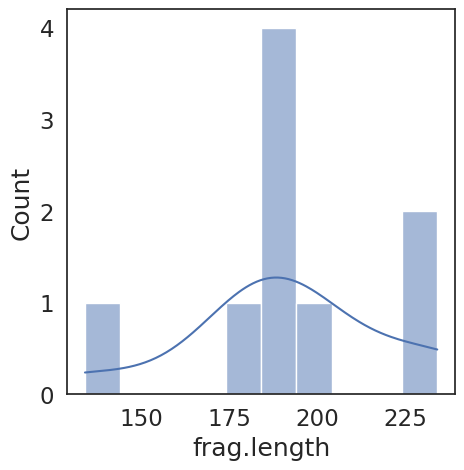

In [75]:
plt.figure(figsize=(5, 5))
sns.histplot(data=mobsnvf_correct_ideafix_wrong_features, x="frag.length", bins=10, kde=True, kde_kws={"bw_adjust": 1})

In [79]:
mobsnvf_correct_features = features.join(mobsnvf_correct, on="snv", how="semi")
mobsnvf_correct_features

allele.freq,alt.bases,norm.alt.bases,ref.bases,norm.ref.bases,ref.allele,alt.allele,base.qual,base.qual.frac,frag.length,pos.from.end,map.qual,FdeamC,SOB,SBGuo,SBGATK,id,both.reads.aligned,norm.pos.from.end,current,bases,before.2,before.1,after.1,after.2,before,after,is.repeat.region,snv
f64,i64,f64,i64,f64,str,str,i64,f64,i64,i64,str,f64,f64,f64,f64,str,i64,f64,str,str,str,str,str,str,str,str,bool,str
0.266,37,0.253425,109,0.746575,"""C""","""T""",22,0.536585,185,25,"""NA""",0.481481,-0.037037,0.029894,0.258757,"""chr1:43977964""",1,0.135135,"""C""","""TCCTG""","""T""","""C""","""T""","""G""","""TC""","""TG""",false,"""chr1_43977964_C_T"""
0.3,18,0.305085,41,0.694915,"""C""","""T""",20,0.540541,210,29,"""NA""",0.272727,-0.454545,0.210114,0.350532,"""chr1:46658589""",1,0.138095,"""C""","""ATCAC""","""A""","""T""","""A""","""C""","""AT""","""AC""",false,"""chr1_46658589_C_T"""
0.237,77,0.215686,280,0.784314,"""C""","""T""",41,1.0,195,34,"""NA""",0.35,-0.3,0.075669,0.225395,"""chr1:119895936""",1,0.174359,"""C""","""CTCGG""","""C""","""T""","""G""","""G""","""CT""","""GG""",false,"""chr1_119895936_C_T"""
0.21,27,0.206107,104,0.793893,"""G""","""A""",35,0.853659,190,24,"""NA""",0.526316,-0.052632,0.233351,0.234528,"""chr1:119966549""",1,0.126316,"""G""","""AGGAA""","""A""","""G""","""A""","""A""","""AG""","""AA""",false,"""chr1_119966549_G_A"""
0.273,38,0.231707,126,0.768293,"""G""","""A""",41,1.108108,199,20,"""NA""",0.413793,0.172414,0.280793,0.268659,"""chr1:150261629""",1,0.100503,"""G""","""ATGGC""","""A""","""T""","""G""","""C""","""AT""","""GC""",false,"""chr1_150261629_G_A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.188,25,0.164474,127,0.835526,"""G""","""A""",20,1.0,183,29,"""NA""",0.444444,0.111111,0.50772,0.215649,"""chr22:23875150""",1,0.15847,"""G""","""GTGGT""","""G""","""T""","""G""","""T""","""GT""","""GT""",false,"""chr22_23875150_G_A"""
0.174,19,0.162393,98,0.837607,"""C""","""T""",41,1.0,208,32,"""NA""",0.5,0.0,0.067669,0.166517,"""chr22:33626099""",1,0.153846,"""C""","""CTCCT""","""C""","""T""","""C""","""T""","""CT""","""CT""",false,"""chr22_33626099_C_T"""
0.145,162,0.141981,979,0.858019,"""G""","""A""",37,1.0,185,26,"""NA""",0.508065,-0.016129,0.03453,0.144703,"""chr22:37374978""",1,0.140541,"""G""","""AGGGG""","""A""","""G""","""G""","""G""","""AG""","""GG""",false,"""chr22_37374978_G_A"""


In [80]:
mobsnvf_correct_features["frag.length"].describe()

statistic,value
str,f64
"""count""",101.0
"""null_count""",0.0
"""mean""",192.584158
"""std""",31.741855
"""min""",126.0
"""25%""",172.0
"""50%""",187.0
"""75%""",207.0
"""max""",305.0


<Axes: xlabel='frag.length', ylabel='Count'>

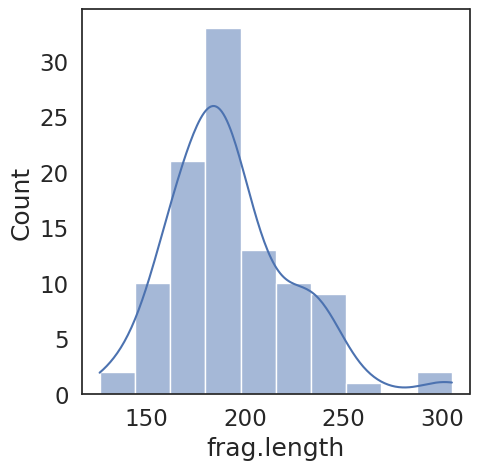

In [82]:
plt.figure(figsize=(5, 5))
sns.histplot(data=mobsnvf_correct_features, x="frag.length", bins=10, kde=True, kde_kws={"bw_adjust": 1})

#### Statistical Tests

In [83]:
u_statistic, p_value = stats.mannwhitneyu(ideafix_correct_mosnvf_wrong_features["frag.length"], mobsnvf_correct_ideafix_wrong_features["frag.length"], alternative='two-sided')
print(f"U-Statistic: {u_statistic}")
print(f"P-Value: {p_value}")

U-Statistic: 92.5
P-Value: 0.40325098195639775


In [84]:
t_stat, p_value = stats.ttest_ind(ideafix_correct_mosnvf_wrong_features["frag.length"], mobsnvf_correct_features["frag.length"], equal_var=False)
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: 1.7036263533349034
P-Value: 0.10608105420099731


In [85]:
t_stat, p_value = stats.ttest_ind(ideafix_correct_mosnvf_wrong_features["frag.length"], mobsnvf_correct_ideafix_wrong_features["frag.length"], equal_var=False)
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: 1.5039042329940495
P-Value: 0.14567553410834977


In [86]:
stats.skew(ideafix_correct_mosnvf_wrong_features["frag.length"])

np.float64(0.6984831144186557)

In [87]:
stats.skew(mobsnvf_correct_ideafix_wrong_features["frag.length"])

np.float64(-0.2852274021580726)

In [88]:
stats.skew(mobsnvf_correct_features["frag.length"])

np.float64(0.9155975036431833)